# Pathfinder Phase Workshop: Processing Data

__Description & purpose__: This Notebook is designed to showcase the functionality of the Earth Observation Data Hub (EODH) as the project approaches the end of the Pathfinder Phase. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of February 2025.   

__Author(s)__: Alastair Graham, Dusan Figala

__Date created__: 2025-02-18

__Date last modified__: 2025-02-21

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

### Presentation set up

The following cell only needs to be run on the EODH AppHub.  If you have a local Python environment running, please install the required packages as you would normally.

In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need at least the following libraries
import sys
!{sys.executable} -m pip install --upgrade pyeodh pandas matplotlib numpy pillow folium

# EODH and EOAP
The EODH compute architecture is built around a collection of OGC standards which when brought together are known as EO Application Packages (EOAP). These are complex constructions of code and data, and at their core is the concept of a Common Workflow Language (CWL) workflow. To run CWL workflows you need a CWL runner, and the EODH Workflow Runner provides that. The EOAPs require a workflow description in CWL, a Docker container, bespoke scripts and links to the data. In the case of EODH, the data inputs and outputs are to be provided as STAC catalogues. Oxidian, as part of our work developing integrations for the Hub, have created a generator tool `eoap-gen` that abstracts away much of the complexity (check out the [training materials repository and website](https://eo-datahub.github.io/eodh-training/) for more details).   

Oxidian have also developed a QGIS plugin to allow desktop users to discover, parameterise and execute workflows on the Hub. We will look at that more at the bottom of this document.

In [ ]:
# Imports
import pyeodh

import os
from requests import HTTPError

First the user needs to connect to the Workflow Runner. You will need your user account name (likely your **GitHub user name** at the time of the workshop) and **API key** (as obtained earlier in the exercises). 

Here, those details have been saved in secrets.txt which contains the two lines below where USERNAME and API_KEY are specific to the user:
* USER="USERNAME"
* PSWD="API_KEY"

You can **either** create a secrets.txt file in the same folder as this Notebook and run the next code cell, **OR** you can manually copy and paste your details details into the next-but-one code cell and run that. Make sure you save your Notebook after making any edits. Do not share your credentials. 

In [ ]:
# Make sure secrets.txt exists in the same folder as this Notebook, and is correctly formatted
# If you have the correct permissions you can join different platforms by changing base_url 

with open('secrets.txt', 'r') as file:
    lines = file.readlines()
    username = lines[0].strip().split('=')[1].strip('"')
    token = lines[1].strip().split('=')[1].strip('"')

clientwfr = pyeodh.Client(base_url="https://staging.eodatahub.org.uk", username=username, token=token)
wfr = clientwfr.get_ades()

In [ ]:
# IGNORE if you ran the previous cell successfully
username = "Replace with your username"
token = "Replace with your API token"

clientwfr = pyeodh.Client(base_url="https://staging.eodatahub.org.uk", username=username, token=token)
wfr = clientwfr.get_ades()

The next cell demonstrates a simple CWL workflow. Do not change the code in this cell or your workflow will return errors.

The workflow takes in an array of file names. These would be URLs to online resources, so you could imagine obtaining them via a search of a STAC catalogue. It then starts gdal in a Docker container and passes the URLs into the container. gdal_translate is then used to resize the resolution of the image pixels to 5% of their original. The outputs are passed to another Docker container that creates a STAC compatible output and stores it in an AWS S3 bucket attached to your workspace.

As you can see, in the case of simple workflows, it is likely easier to use the base commands. However, if you want to generate STAC outputs, or run any workflow where it acts as a service, or need connections between platforms, then there are situations where EOAPs can be beneficial. 

In [ ]:
cwl_yaml = r"""$graph:
- class: CommandLineTool
  id: 'resize_make_stac'
  inputs:
  - id: 'files'
    doc: FILES
    type:
      type: array
      items: File
    inputBinding: {}
  requirements:
  - class: DockerRequirement
    dockerPull: ghcr.io/eo-datahub/user-workflows/resize_make_stac:main
  - class: InlineJavascriptRequirement
  doc: "None\n"
  baseCommand:
  - python
  - /app/app.py
  outputs:
  - id: 'stac_catalog'
    outputBinding:
      glob: .
    type: Directory
- class: CommandLineTool
  inputs:
  - id: 'url'
    inputBinding:
      position: 1
      prefix: /vsicurl/
      separate: false
    type: string
  - id: 'fname'
    inputBinding:
      position: 2
      valueFrom: $(inputs.url.split('/').pop() + "_resized.tif")
    type: string
  - id: 'outsize_x'
    inputBinding:
      position: 4
      prefix: -outsize
      separate: true
    type: string
  - id: 'outsize_y'
    inputBinding:
      position: 5
    type: string
  outputs:
  - type: File
    outputBinding:
      glob: '*.tif'
    id: 'resized'
  requirements:
  - class: DockerRequirement
    dockerPull: ghcr.io/osgeo/gdal:ubuntu-small-latest
  - class: InlineJavascriptRequirement
  baseCommand: gdal_translate
  id: 'resize_process'
- class: Workflow
  id: 'resize-urls'
  inputs:
  - id: 'urls'
    label: urls
    doc: urls
    type:
      type: array
      items: string
  - id: 'outsize_x'
    label: outsize_x
    doc: outsize_x
    default: 5%
    type: string
  - id: 'outsize_y'
    label: outsize_y
    doc: outsize_y
    default: 5%
    type: string
  outputs:
  - id: 'stac_output'
    outputSource:
    - 'resize_make_stac/stac_catalog'
    type: Directory
  requirements:
  - class: ScatterFeatureRequirement
  - class: StepInputExpressionRequirement
  - class: InlineJavascriptRequirement
  label: Resize urls
  doc: Resize urls
  steps:
  - id: 'resize_process'
    in:
    - id: 'outsize_x'
      source: 'outsize_x'
    - id: 'outsize_y'
      source: 'outsize_y'
    - id: 'url'
      source: 'urls'
    - id: 'fname'
      valueFrom: $(inputs.url.split('/').pop() + "_resized.tif")
    out:
    - id: 'resized'
    run: '#resize_process'
    scatter:
    - 'url'
    scatterMethod: dotproduct
  - id: 'resize_make_stac'
    in:
    - id: 'files'
      source: 'resize_process/resized'
    out:
    - id: 'stac_catalog'
    run: '#resize_make_stac'
cwlVersion: v1.0
"""

If you try to deploy a workflow that already exists (i.e. with the same name) in the EODH, you will get an error. It is therefore good practice to run a check and delete any process with the same name - assuming you are confident that you want to overwrite it. Otherwise, consider renaming your workflow.

In [ ]:
try:
    wfr.get_process("resize-urls").delete()
except Exception:
    print("Process not found, no need to undeploy.")

In [ ]:
# Deploy the CWL workflow code to the workflow runner
process = wfr.deploy_process(cwl_yaml=cwl_yaml)

If you want to know what workflows you have access to in your workspace on the Hub, the following code will create a print out.

In [ ]:
# List the workflows available in the user workspace
for p in wfr.get_processes():
    print(p.id)

In [ ]:
myjob = wfr.get_process("resize-urls").execute(
    {
        "urls": [
            "https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn501lonw0036_T30UVA_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif",
            "https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/20/S2A_20231120_latn519lonw0037_T30UVC_ORB037_20231120132420_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif",
        ],
    }
)
print("job submitted")

In [ ]:
myjob.self_href

If you follow the URL output from the previous cell you will see something similar to the following. The two immediately helpful bits of information are the `jobID` and `status` (hopefully it's successful!). You will need to be logged in to your EODH account to be able to view this file and any links from it as these are tied to your workspace. as you can hopefully see from the cell below, there are logs to each of the stages of the workflow, all of which are accessible.

Following the final URL (node_stage_out.log in the case above) should take you to a detailed log of the full process. A selection of that log is shown in the cell below. From here it is possible to access the resized output files (ending in `_resized.tif`) and download them. They are also catalogued in STAC so you can use pyeodh to access them, or you can use the Catalogue user interface and look under `User Datasets` for a catalogue with the same `Job_ID` and find links to the outputs that way.   

The difference in the input (top) and output (bottom) (for this cloudy image!) is shown below:

![](images/11.png "Input image") 

![](images/12.png "Output image")

As development continues the number of demonstration workflows available to users should increase. With uptake of the generator tool, users will also be able to create their own bespoke workflows. In time, the Hub will contain organisational accounts and the ability to share workflow files.

If a user wants to deploy a workflow that they have found online, they can do so for compliant CWL files by submitting the URL (as shown below). 

n.b. you need the raw content link of the workflow resource. The resource can be found [here](https://github.com/EO-DataHub/eodhp-ades-demonstration/blob/e4ed00b16add58f9b516921ca9ca9e1068dd27c1/convert-url-app.cwl) and a repository of examples [here](https://github.com/EO-DataHub/eodhp-ades-demonstration) 

In [ ]:
# Deploy a workflow using a URL to a .cwl file hosted online
convert_url_proc = wfr.deploy_process(
    cwl_url="https://raw.githubusercontent.com/EO-DataHub/eodhp-ades-demonstration/e4ed00b16add58f9b516921ca9ca9e1068dd27c1/convert-url-app.cwl"
)
print(convert_url_proc.id, convert_url_proc.description, ": Deployed")
print('')
# List the available workflows
for p in wfr.get_processes():
    print(p.id)

In [ ]:
# Tidy up youe Workflow Runner userspace

try:
    wfr.get_process("resize-urls").delete()
    wfr.get_process("convert-url").delete()
except Exception:
    print("Process not found, no need to undeploy.")

If needed for tracking the progress of a workflow, you can enable verbose logging using th efollowing code. Set this in the same cell as the import statements, at the end of the cell.

`pyeodh.set_log_level(10)` 

# Other interactions with workflows

Screenshots are provided here for the QGIS Plugin. If you are a user of QGIS the plugin is now available in the Plugin Repository and can be installed in the usual way.

Once a CWL file has been deployed to a user's workspace (or in future, to organisational or shared workspaces) then it is possible for users with suitable permissions to view their list of available workflows through the QGIS plugin.

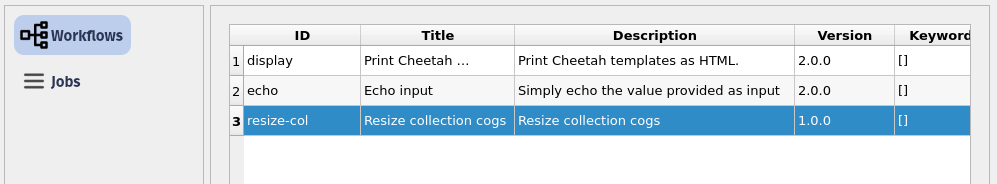

The user can choose and parameterise a workflow using the QGIS plugin as shown in this screenshot. A series of defaults are provided with all workflow files so a user can run the workflow straight away using those. To do so in code, the user provides an empty dictionary. 

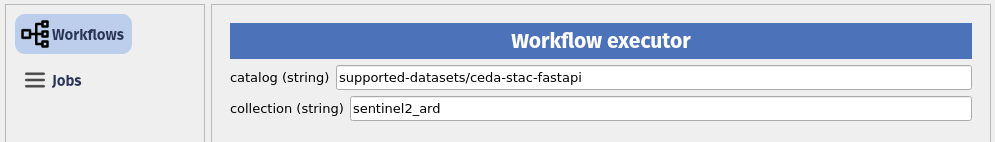

The status of a running job: `"status": "running"` can be monitored using the QGIS plugin.

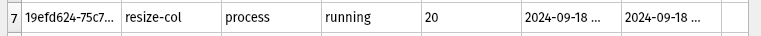

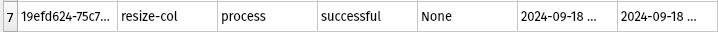

The outputs are accessible and loadable from the QGIS plugin.

Original image: 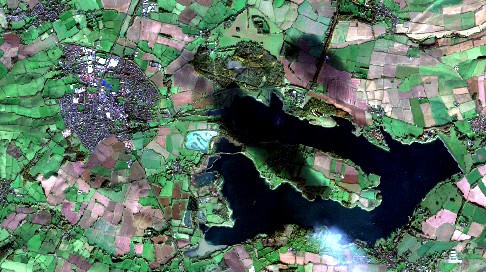  

Resampled image: 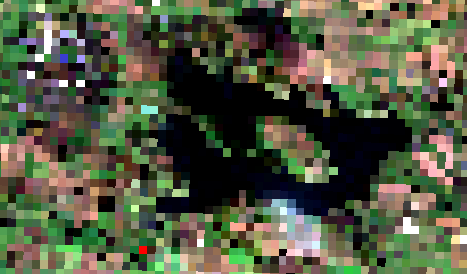

The workflow outputs are available in a users's workspace and are attached to the `job id` presented through the QGIS plugin. A user can open the workflow output from within the plugin to be displayed in the QGIS map window. 